In [1]:
import numpy as np
import csv
import png
from matplotlib import pyplot as plt
import cv2 as cv

undistort_mtx = np.array([[292.00435998,   0.,         184.46231254],
 [  0.,         290.13777429, 145.5500931 ],
 [  0.,           0.,           1.        ]])

undistort_newcameramtx = np.array([[219.46858215,   0.,         184.57709806],
 [  0.,         207.91963196, 150.10088495],
 [  0.,           0. ,          1. ,       ]])

undistort_dist = np.array([[-0.35620774,  0.35086004, -0.00051231,  0.0015257,  -0.38282677]])

undistort_roi = (46,46,265,205)

def load_n_undistort(filename):
    with open(filename, newline='') as csvfile:
        data = list(csv.reader(csvfile,  delimiter=';'))
        
    dataraw = np.array(data)
    dataraw = dataraw.astype(np.uint16).reshape((286,352))
    dataRGB = np.zeros((286*352*3),dtype=float).reshape((286,352,3))
    dataRGB[:,:,0] = (((dataraw[:,:]-np.amin(dataraw).astype(float))/(np.amax(dataraw)-np.amin(dataraw))).astype(float)).astype(float)
    dataRGB[:,:,1] = (((dataraw[:,:]-np.amin(dataraw).astype(float))/(np.amax(dataraw)-np.amin(dataraw))).astype(float)).astype(float)
    dataRGB[:,:,2] = (((dataraw[:,:]-np.amin(dataraw).astype(float))/(np.amax(dataraw)-np.amin(dataraw))).astype(float)).astype(float)
    dst = cv.undistort(dataRGB, undistort_mtx, undistort_dist, None, undistort_newcameramtx)
    x, y, w, h = undistort_roi
    src = dst[y:y+h, x:x+w]
    return src

def sobel_filter_2D(src):
    sobel_x = np.array([[-1., 0., 1.],
                        [-2., 0., 2.],
                        [-1., 0., 1.]])
    sobel_y = np.array([[-1., -2., -1.],
                        [0., 0., 0.],
                        [1., 2., 1.]])
    if len(src.shape)==3:
        width, height, channels = src.shape
    elif len(src.shape)==2:
        width, height = src.shape
        channels = 1
    else:
        return
    dst_x = np.zeros(src.shape,dtype=float)
    dst_y = np.zeros(src.shape,dtype=float)
    dst = np.zeros(src.shape,dtype=float)
    dst_x = cv.filter2D(src,-1,sobel_x)
    dst_y = cv.filter2D(src,-1,sobel_y)
    for c in range(channels):
        for x in range(width):
            for y in range(height):
                dst[x,y,c] = dst_x[x,y,c]-dst_y[x,y,c]
    return dst

def sub_images_2D(src_pos, src_neg):
    if src_pos.shape != src_neg.shape:
        return
    if len(src_pos.shape)==3:
        width, height, channels = src_pos.shape
    elif len(src_pos.shape)==2:
        width, height = src_pos.shape
        channels = 1
    else:
        return
    dst = np.zeros(src_pos.shape,dtype=float)
    for c in range(channels):
        for x in range(width):
            for y in range(height):
                dst[x,y,c] = np.sqrt(src_pos[x,y,c]*src_pos[x,y,c]+src_neg[x,y,c]*src_neg[x,y,c])
    return dst

def mul_images_2D(src1, src2):
    if src1.shape != src2.shape:
        return
    if len(src1.shape)==3:
        width, height, channels = src1.shape
    elif len(src1.shape)==2:
        width, height = src1.shape
        channels = 1
    else:
        return
    dst = np.zeros(src1.shape,dtype=float)
    for c in range(channels):
        for x in range(width):
            for y in range(height):
                dst[x,y,c] = src1[x,y,c]*src2[x,y,c]
    return dst

Load flat image

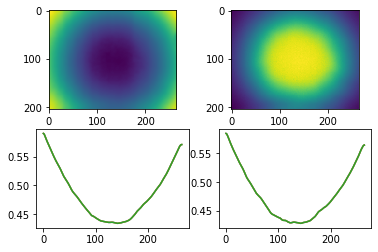

In [2]:

ampl = load_n_undistort("../data/ToFData/ampl_flat_roof_diffusor_16.txt")
width, height, channels = ampl.shape
radial_arr = np.zeros((width, height, channels, 18),dtype=float)
filenameprefix = "../data/ToFData/radial_flat_roof_diffusor_"
filenamesuffix = ".txt"
for i in range(18):
    filename = filenameprefix+str(i)+filenamesuffix
    radial_arr[:,:,:,i] = load_n_undistort(filename)
    radial_arr[:,:,:,i] = cv.GaussianBlur(radial_arr[:,:,:,i],(0,0),2)
radial = np.mean(radial_arr, axis=3)




plt.subplot(221)
plt.imshow(radial[:,:,0], interpolation='nearest')
plt.subplot(222)
plt.imshow(ampl[:,:,0], interpolation='nearest')
plt.subplot(223)
plt.plot(radial[80,:])
plt.subplot(224)
plt.plot(radial[105,:])
plt.show()


Tryout of derivative - needs lots of smoothing

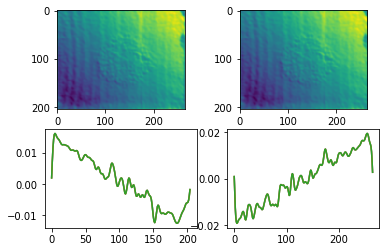

In [3]:
filtered1 = sobel_filter_2D(radial)

plt.subplot(221)
plt.imshow(filtered1[:,:,0], interpolation='nearest')
plt.subplot(222)
plt.imshow(filtered1[:,:,0], interpolation='nearest')
plt.subplot(223)
plt.plot(filtered1[:,125])
plt.subplot(224)
plt.plot(filtered1[105,:])
plt.show()

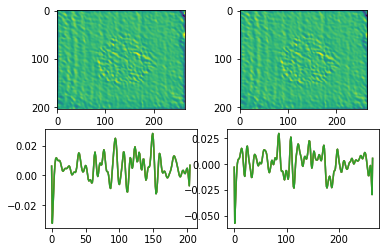

In [4]:
filtered2 = sobel_filter_2D(filtered1)

plt.subplot(221)
plt.imshow(filtered2[:,:,0], interpolation='nearest')
plt.subplot(222)
plt.imshow(filtered2[:,:,0], interpolation='nearest')
plt.subplot(223)
plt.plot(filtered2[:,125])
plt.subplot(224)
plt.plot(filtered2[105,:])
plt.show()

Tryout for simple "reference image subtraction"

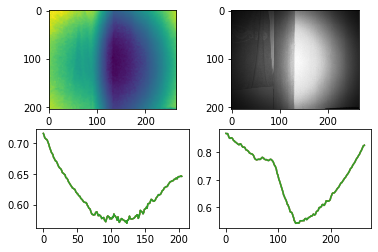

In [5]:
ampl_1 = load_n_undistort("../data/ToFData/ampl_test_diffusor_4.txt")
radial_1 = load_n_undistort("../data/ToFData/radial_test_diffusor_4.txt")

res = sub_images_2D(radial_1,radial)

plt.subplot(221)
plt.imshow(res[:,:,0], interpolation='nearest')
plt.subplot(222)
plt.imshow(ampl_1, interpolation='nearest')
plt.subplot(223)
plt.plot(res[:,125])
plt.subplot(224)
plt.plot(res[105,:])
plt.show()

It's a cos-Function...

(205, 265, 3)


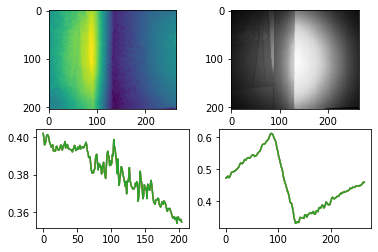

In [6]:
if len(radial.shape)==3:
    width, height, channels = radial.shape
elif len(radial.shape)==2:
    width, height = radial.shape
    channels = 1

cos_a = np.zeros(radial.shape,dtype=float)
print(radial.shape)
for c in range(channels):
    for x in range(width):
        for y in range(height):
            cos_a[x,y,c] = radial[102,132,c]/radial[x,y,c]


res = mul_images_2D(radial_1,cos_a)

plt.subplot(221)
plt.imshow(res[:,:,0], interpolation='nearest')
plt.subplot(222)
plt.imshow(ampl_1, interpolation='nearest')
plt.subplot(223)
plt.plot(res[:,125])
plt.subplot(224)
plt.plot(res[105,:])
plt.show()

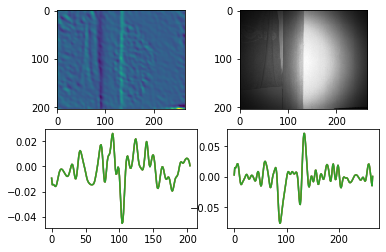

In [7]:
res1 = cv.GaussianBlur(res,(0,0),3)
res2 = sobel_filter_2D(res1)
res3 = sobel_filter_2D(res2)

plt.subplot(221)
plt.imshow(res3[:,:,0], interpolation='nearest')
plt.subplot(222)
plt.imshow(ampl_1, interpolation='nearest')
plt.subplot(223)
plt.plot(res3[:,125])
plt.subplot(224)
plt.plot(res3[105,:])
plt.show()